# Inference Guide


## Overview

We construct a promptable [ImageDecoder](../tokenize_anything/modeling/image_decoder.py) by adding a semantic token to each mask token. The semantic token is pre-trained to align EVACLIP-5B on SA-1B masks in a concept space merged from common datasets, thus it can be used for classification on a dataset-specific concept vocabulary. The semantic token is also used to prompt a [TextDecoder](../tokenize_anything/modeling/text_decoder.py) fine-tuning the 3.8M Visual Genome region captions. Therefore, **TAP** can conduct comprehensive understanding of arbitrary image regions.


## Setup

Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

np.random.seed(1234)
inference_mode = torch.inference_mode()
inference_mode.__enter__()

def show_mask(mask, ax):
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    ax.imshow(mask.reshape(mask.shape[-2:] + (1,)) * color.reshape(1, 1, -1))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


## Build

First, build the default ``TAP-L`` model.


In [2]:
import sys
sys.path.append("..")
from tokenize_anything import model_registry, TapPredictor, TapAutomaticMaskGenerator

model_type = "tap_vit_l"
checkpoint = "../checkpoints/tap/tap_vit_l_03f8ec.pkl"
tap = model_registry[model_type](checkpoint=checkpoint).cuda()
tap_predictor = TapPredictor(tap)
mask_generator = TapAutomaticMaskGenerator(tap)

To predict concepts and generate captions, setup [ConceptProjector](../tokenize_anything/modeling/concept_projector.py) and [TextDecoder](../tokenize_anything/modeling/text_decoder.py).

In [3]:
# concept_weights = "../checkpoints/tap/merged_2560.pkl"
# model.concept_projector.reset_weights(concept_weights)
tap.text_decoder.reset_cache(max_batch_size=1024)


## Preprocessing

Next, load and show the ``fairytale`` image.

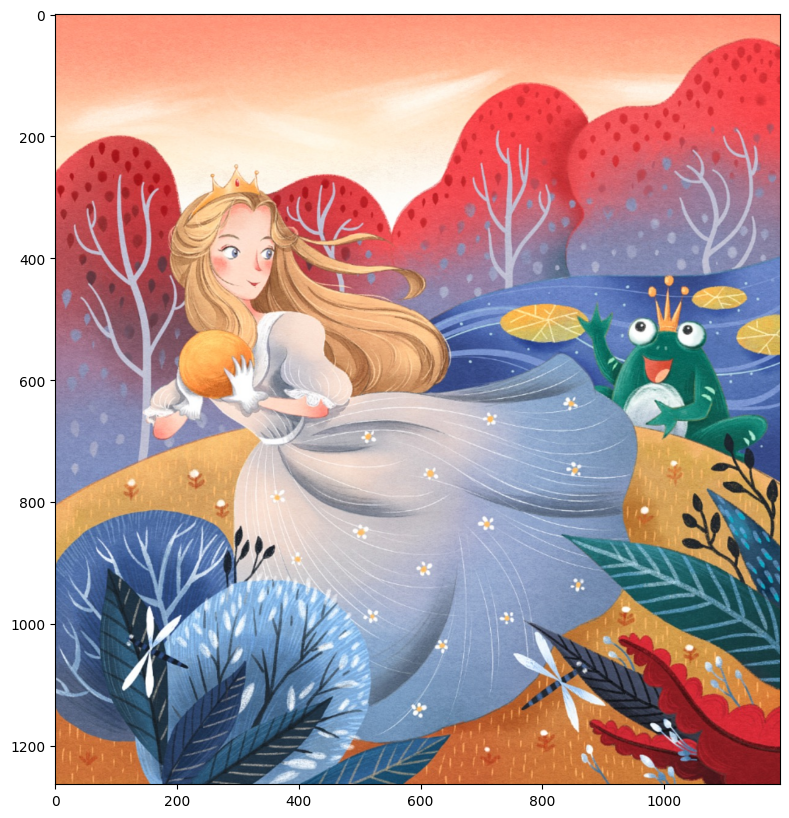

In [4]:
img = cv2.imread("images/fairytale.jpg")
vis_img = img.copy()[:, :, ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(vis_img)
plt.show()


## Everything Mode

Resize image to match the maximal side length ``1024``.

In [5]:
masks = mask_generator.generate(img)

In [6]:
len(masks)

40

In [7]:
masks[1]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 7089,
 'bbox': [731, 475, 139, 64],
 'predicted_iou': 0.9892578125,
 'point_coords': [[799.53125, 533.25]],
 'stability_score': 0.9707927703857422,
 'crop_box': [0, 0, 1190, 1264],
 'caption': 'yellow circle on the rug',
 'sem_token': array([-1.311   ,  0.518   , -0.513   , -0.3967  ,  0.1896  ,  0.7305  ,
        -2.654   , -0.684   ,  0.702   ,  0.662   ,  2.18    , -1.861   ,
         0.978   ,  0.7534  ,  0.604   ,  0.9927  , -0.4624  ,  0.3457  ,
        -0.4497  ,  0.01452 , -0.192   ,  1.833   ,  0.653   ,  0.9365  ,
        -1.825   , -0.3845  , -0.7993  , -0.533   , -0.1658  ,  0.2961  ,
         0.545

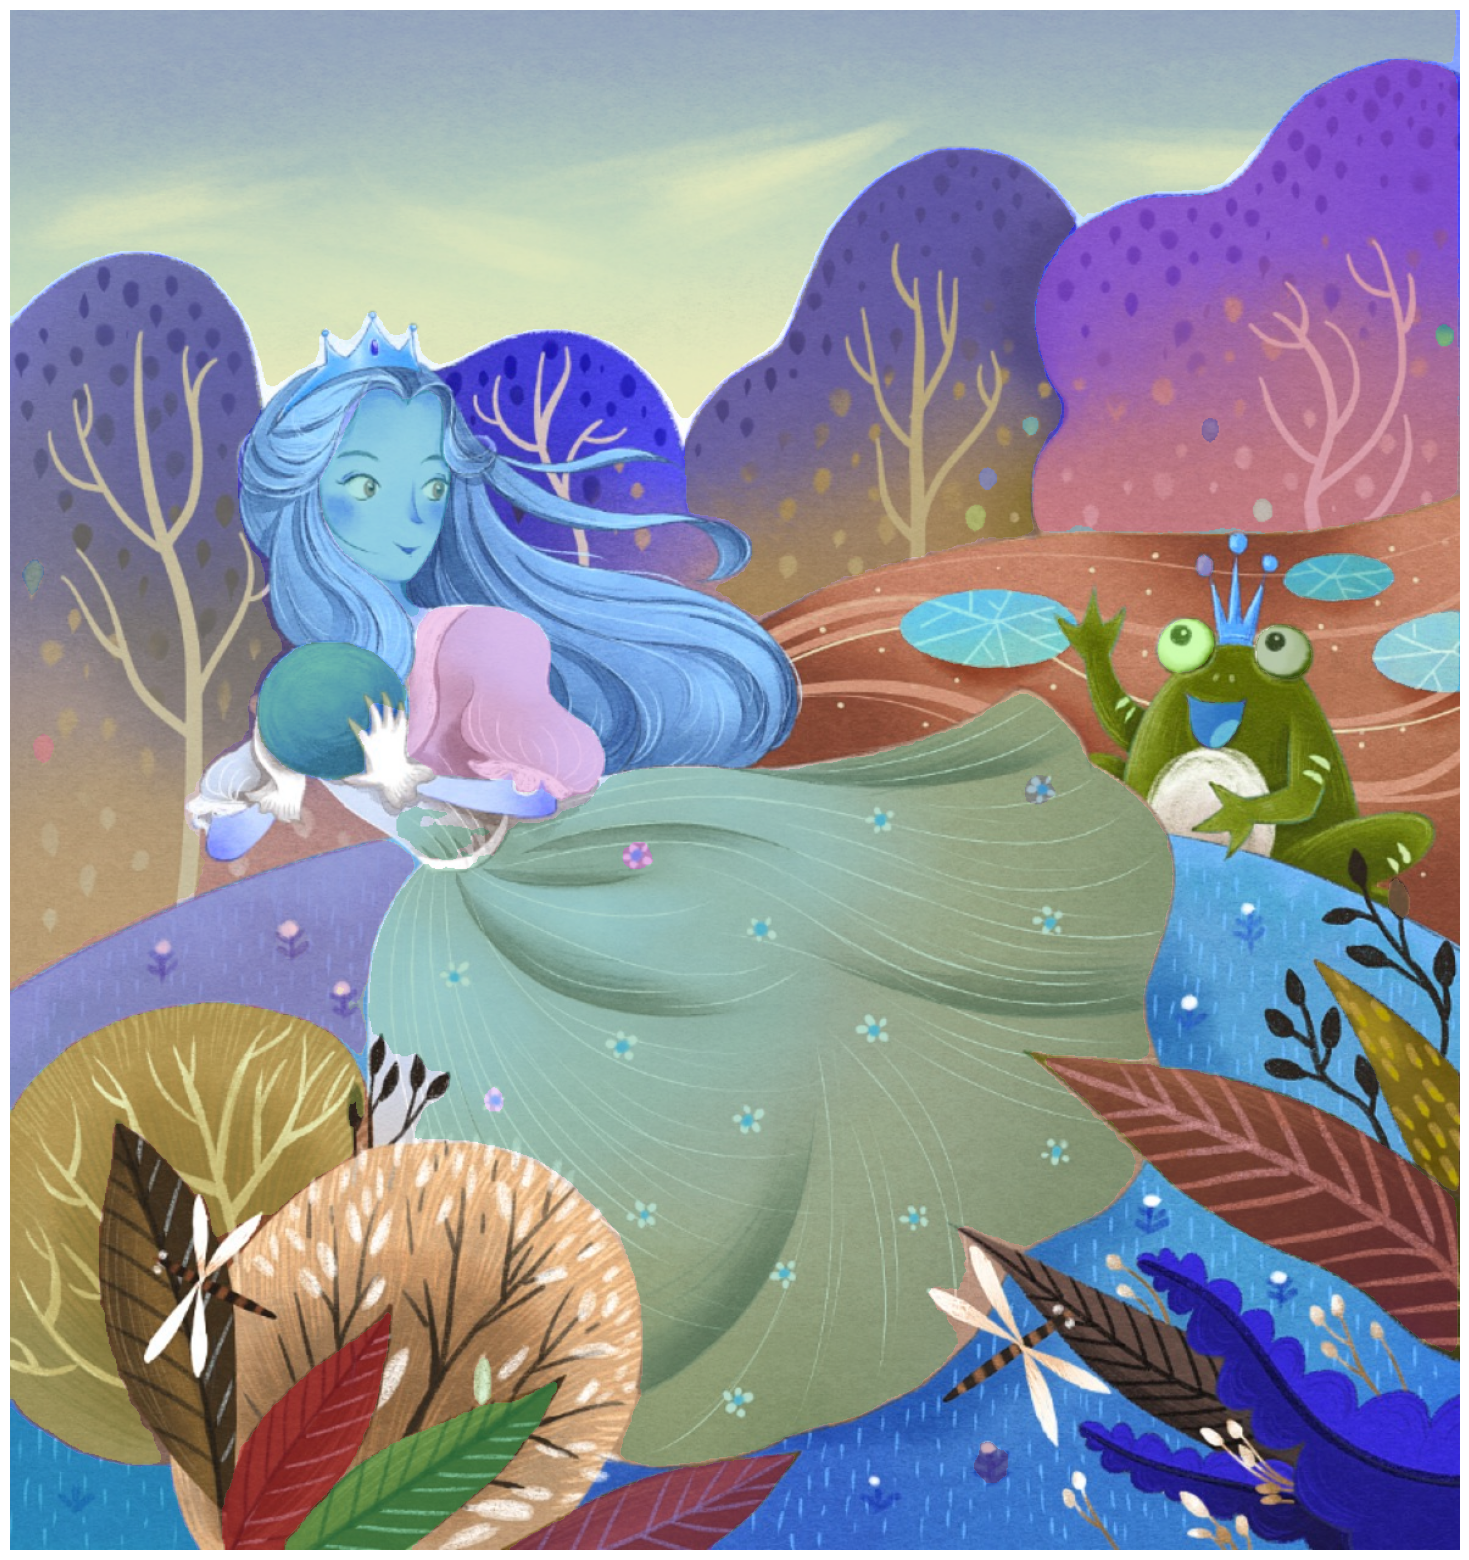

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show() 

Stack and pad image into a batch tensor of size ``(1, 1024, 1024, 3)`` to compute ``img_embeds``. 

## Visual Prompt Decoding: Point

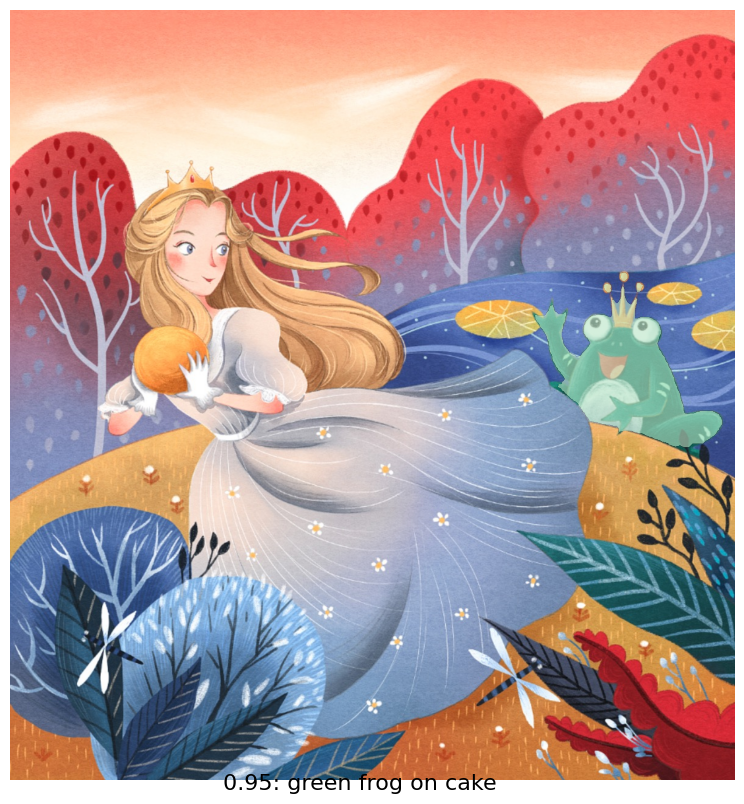

In [9]:
tap_predictor.set_image(img)
masks, ious, _, captions, _ = tap_predictor.predict(np.array([[[1050, 600, 1], [0, 0, 4]]], "float32"))
text_contents = [v.flatten()[0] for v in (ious, captions)]
vis_text = "{:.2f}: {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()

## Visual Prompt Decoding: Box

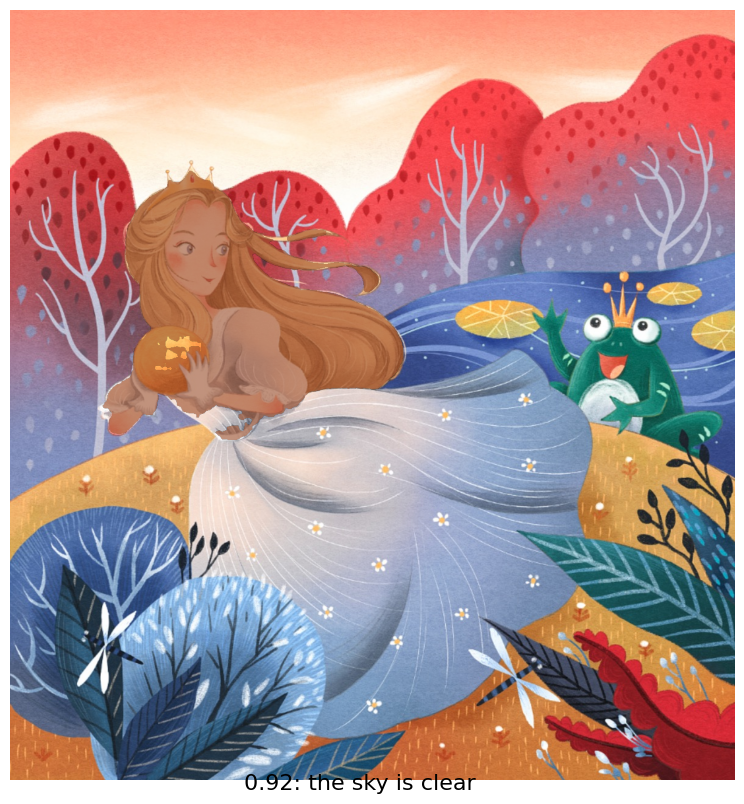

In [11]:
masks, ious, _, captions, _ = tap_predictor.predict(np.array([[[163, 237, 2], [682, 722, 3]]], "float32"))
text_contents = [v.flatten()[0] for v in (ious, captions)]
vis_text = "{:.2f}: {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()


## Visual Prompt Decoding: Sketch

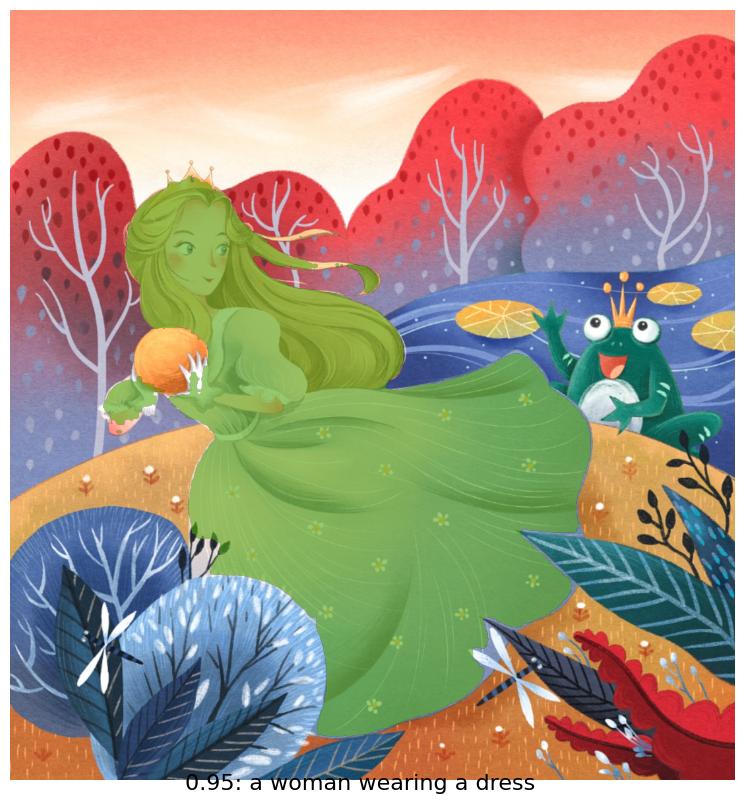

In [12]:
masks, ious, _, captions, _ = tap_predictor.predict(np.array([[
    [255, 337, 1], [295, 435, 1], [411, 598, 1], [415, 782, 1],
    [494, 937, 1], [702, 1090, 1], [812, 906, 1], [849, 748, 1], 
    [783, 627, 1], [0, 0, 4],
]], "float32"))
text_contents = [v.flatten()[0] for v in (ious, captions)]
vis_text = "{:.2f}: {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()
